# Enformer human validation 

### Load  pre-trained model 

In [1]:
import gzip
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import pickle
import sys
import tensorflow as tf
import copy

2022-02-01 15:52:16.616373: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-01 15:52:16.616390: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import importlib 
spec_utils = importlib.util.spec_from_file_location("enformer", os.path.join(os.getcwd() ,"utils/utils.py"))
utils = importlib.util.module_from_spec(spec_utils)
spec_utils.loader.exec_module(utils)
from utils import * 

In [3]:
spec_utils.loader.exec_module(utils)


### Load files

In [4]:
model_path = 'https://tfhub.dev/deepmind/enformer/1'
datadir = "../../../../data/FED"
outputdir = os.path.join(datadir, "hd5")
fasta_file = os.path.join(datadir, "hg38.fa")
human_sequences = os.path.join(datadir, "data_human_sequences.bed")
pyfaidx.Faidx(fasta_file)

Faidx("../../../../data/FED/hg38.fa")

In [5]:
model = utils.Enformer(model_path)

2022-02-01 15:52:42.655640: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-01 15:52:42.655659: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-01 15:52:42.655673: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (luisasantus-HP-EliteDesk-800-G5-TWR): /proc/driver/nvidia/version does not exist
2022-02-01 15:52:42.655832: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-01 15:52:43.824010: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Alloc

In [6]:
# import enformer.py as module
spec = importlib.util.spec_from_file_location("enformer", os.path.join(os.getcwd() ,"utils/enformer.py"))
enformer = importlib.util.module_from_spec(spec)
spec.loader.exec_module(enformer)


In [7]:
    from utils.enformer import * 
    from utils.utils import * 

In [8]:
fasta_extractor = utils.FastaStringExtractor(fasta_file)

In [73]:
# Load previous validation dictionary
dataset_197k_file = os.path.join(outputdir,'test_197k_valid.h5')

with open(dataset_197k_file, 'rb') as config_dictionary_file:
    dataset_197k = pickle.load(config_dictionary_file)

# Evaluate per track 

In [74]:
SEQUENCE_LENGHT = 393_216
## pad the sequence with Ns (anyways ignored by the model)
def pad_one_hot(sequence_one_hot, NEW_SIZE):
    ADD_ENDS = int((NEW_SIZE - sequence_one_hot.shape[0])/2)
    pad_zero = np.tile(np.array([0., 0., 0., 0.]), (ADD_ENDS, 1))
    padded_left = np.append(pad_zero,sequence_one_hot, axis=0)
    pad_sequence = np.append(padded_left,pad_zero, axis=0)
    return(pad_sequence)

In [75]:
def evaluate_model_all_sequences_mod(model, dataset, head, max_steps=None):
    
    metric = MetricDict({'PearsonR': PearsonR(reduce_axis=(0,1))})
    
    # Given a tensor with a one-encoded sequence, predicts head tracks
    def predict(x):
        padded_sequence = pad_one_hot(np.squeeze(x.numpy(), axis=0), SEQUENCE_LENGHT)[np.newaxis]
        predictions = model.predict_on_batch(padded_sequence)[head]
        return tf.convert_to_tensor(predictions, dtype=tf.float32)
    
    i = 0 
    for i, batch in enumerate(dataset_197k): 
        if max_steps is not None and i > max_steps:
            break
        i = i+1
        prediction = predict(batch['sequence'])
        metric.update_state(batch['target'], prediction)

    return metric.result()

In [76]:

dataset_197k_evaluation = copy.deepcopy(dataset_197k)

In [87]:
max_steps = float("inf")

In [130]:
def evaluate_model_all_sequences_mod(model, dataset, head, dataset_197k_evaluation, max_steps=None):
    
    metric = MetricDict({'PearsonR': PearsonR(reduce_axis=(0,1))})
    
    # Given a tensor with a one-encoded sequence, predicts head tracks
    def predict(x):
        padded_sequence = pad_one_hot(np.squeeze(x.numpy(), axis=0), SEQUENCE_LENGHT)[np.newaxis]
        predictions = model.predict_on_batch(padded_sequence)[head]
        return tf.convert_to_tensor(predictions, dtype=tf.float32)
    
    for i in range(len(dataset_197k)):
        
        if max_steps is not None and i > max_steps:
            break
        
        batch = dataset_197k[i]
        prediction = predict(batch['sequence'])
        metric.update_state(batch['target'], prediction)
        # Compute it on a sequence basis
        metric_seq = MetricDict({'PearsonR': PearsonR(reduce_axis=(0,1))})
        metric_seq.update_state(batch['target'], prediction)
        dataset_197k_evaluation[i]["PearsonR"] = metric.result()["PearsonR"].numpy()
        print(i)
        print(dataset_197k_evaluation[i]["PearsonR"])
    return list([metric.result(), dataset_197k_evaluation])

In [139]:
metrics_human = evaluate_model_all_sequences_mod(model,
                               dataset=dataset_197k,
                               head='human',
                               dataset_197k_evaluation = dataset_197k_evaluation,
                               max_steps=float("inf"))

0
[0.9088842  0.86464256 0.79959553 ... 0.14443839 0.12650977 0.23051044]
1
[0.75401574 0.81730115 0.7710098  ... 0.14281958 0.28405324 0.27569246]
2
[0.7743782  0.84019333 0.78300387 ... 0.11830644 0.2106817  0.17681527]
3
[0.76783895 0.78569883 0.73060596 ... 0.13456136 0.15965948 0.17457812]


In [140]:
summarized_metrics = metrics_human[0]
dataset_197k_evaluation = metrics_human[1]

In [ ]:
file = os.path.join(outputdir,'dataset_197k_evaluation.h5')
# Step 2
with open(file, 'wb') as config_dictionary_file:
    pickle.dump(dataset_197k_evaluation, config_dictionary_file)

# Plot sequences summary

In [125]:
ordered_assays = suppl_df[suppl_df["organism"] == "human"]["assay_type"]

In [126]:
pd.DataFrame(suppl_df[suppl_df["organism"] == "human"].groupby("assay_type").count()["index"])

,index
assay_type,
ATAC,10
CAGE,638
CHIP,3991
DNASE,674


In [142]:
def get_sequence_evaluation_df(i,dataset_197k_evaluation, ordered_assays ):
    # Create dataframe for plotting
    df = pd.DataFrame()
    # Add sequence
    df["sequence"] = np.repeat(1,len(ordered_assays))
    # Add assay
    df["assay"] = ordered_assays
    # Add pearson values 
    df["pearson"] = (dataset_197k_evaluation[i]["PearsonR"])
    return(df)

In [143]:
final_df = pd.DataFrame()
for i in range(len(dataset_197k_evaluation)):
    df = get_sequence_evaluation_df(i,dataset_197k_evaluation, ordered_assays)
    print(i)
    final_df = pd.concat([final_df, df])

0
1
2
3


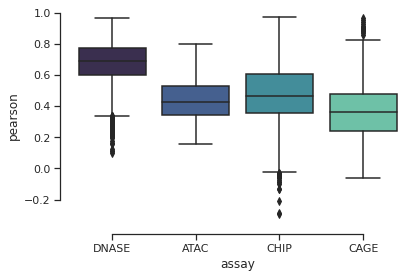

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks", palette="pastel")

# Load the example tips dataset

# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="assay", y="pearson",  palette="mako",
            data=final_df)

sns.despine(offset=10, trim=True)

In [136]:
# Load previous validation dictionary
enformer_dict_file = os.path.join(outputdir,'00_enformer_dict_seqs.h5')

with open(enformer_dict_file, 'rb') as config_dictionary_file:
    human_validation_dict = pickle.load(config_dictionary_file)

In [138]:
human_validation_dict

{Interval(chrom='chr6', start=165740202, end=165871274, name='', strand='.', ...): array([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]], dtype=float32),
 Interval(chrom='chrX', start=55044496, end=55175568, name='', strand='.', ...): array([[0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]], dtype=float32),
 Interval(chrom='chrX', start=84489673, end=84620745, name='', strand='.', ...): array([[0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]], dtype=float32),
 Interval(chrom='chrX', start=26382093, end=26513165, name='', strand='.', ...): array([[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        ...,
        [1., 0., 0., 0.],
   

### Check tracks

In [15]:
# Download targets from Basenji2 dataset 
# Cite: Kelley et al Cross-species regulatory sequence activity prediction. PLoS Comput. Biol. 16, e1008050 (2020).
targets_txt = 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt'
df_targets = pd.read_csv(targets_txt, sep='\t')
df_targets

,index,genome,identifier,file,clip,scale,sum_stat,description
0,0,0,ENCFF833POA,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:cerebellum male adult (27 years) and mal...
1,1,0,ENCFF110QGM,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:frontal cortex male adult (27 years) and...
2,2,0,ENCFF880MKD,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:chorion
3,3,0,ENCFF463ZLQ,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:Ishikawa treated with 0.02% dimethyl sul...
4,4,0,ENCFF890OGQ,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:GM03348
...,...,...,...,...,...,...,...,...
5308,5308,0,CNhs14239,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:epithelioid sarcoma cell line:HS-ES-2R
5309,5309,0,CNhs14240,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:squamous cell lung carcinoma cell line:RE...
5310,5310,0,CNhs14241,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:gastric cancer cell line:GSS
5311,5311,0,CNhs14244,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:carcinoid cell line:NCI-H727


In [16]:
suppl = pd.ExcelFile(os.path.join(datadir, "enformer_suppl.xlsx"))
print(suppl.sheet_names)
suppl_human = suppl.parse(suppl.sheet_names[1])
suppl_mouse = suppl.parse(suppl.sheet_names[2])
suppl_human["organism"] = "human"
suppl_mouse["organism"] = "mouse"
frames = [suppl_human, suppl_mouse]
suppl_df = pd.concat(frames)

['Supplementary Table 1', 'Supplementary Table 2', 'Supplementary Table 3']


In [145]:

file = os.path.join(outputdir,'suppl_df.h5')
with open(file, 'wb') as config_dictionary_file:
    pickle.dump(suppl_df, config_dictionary_file)

### compute score (how well predicted)

In [43]:
#TODO 
#1 - retrieve the 197k sequence instead o 131k 
prefix = "gs://basenji_barnyard/data"

In [44]:
human_dataset = get_dataset('human', 'valid', prefix).batch(1).repeat()

2022-02-01 12:24:02.190772: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


In [ ]:
type(human_dataset)

In [ ]:
def evaluate_model_all_sequences(model, dataset, head, max_steps=None):
    
    metric = MetricDict({'PearsonR': PearsonR(reduce_axis=(0,1))})
    print("Metric dictionary created")
    
    def predict(x):
        print("Beginning prediction")
        padded_sequence = pad_one_hot(np.squeeze(x.numpy(), axis=0), SEQUENCE_LENGHT)[np.newaxis]
        predictions = model.predict_on_batch(padded_sequence)[head]
        return tf.convert_to_tensor(predictions, dtype=tf.float32)
    print("Predict funciton loaded")
    
    for i, batch in tqdm(enumerate(dataset)):
        if max_steps is not None and i > max_steps:
            break
        prediction = predict(batch['sequence'])
        metric.update_state(batch['target'], prediction)

    return metric.result()

In [ ]:
# Evaluate model on first ten 
# Right now it evaluates the whole model and 
metrics_human = evaluate_model_all_sequences(model,
                               dataset=get_dataset('human', 'valid').batch(1).prefetch(2),
                               head='human',
                               max_steps=2)
#print('')dataset_197k
#print({k: v.numpy().mean() for k, v in metrics_human.items()})

In [ ]:
def evaluate_model_all_sequences(model, sequence_dict, head, max_steps=None):
    
    metric = MetricDict({'PearsonR': PearsonR(reduce_axis=(0,1))})
    print("Metric dictionary created")
    
    def predict(x):
        print("Beginning prediction")
        padded_sequence = pad_one_hot(np.squeeze(x.numpy(), axis=0), SEQUENCE_LENGHT)[np.newaxis]
        predictions = model.predict_on_batch(padded_sequence)[head]
        return tf.convert_to_tensor(predictions, dtype=tf.float32)
    print("Predict funciton loaded")
    
    i = 0 
    for keys in sequence_dict.keys():
        if max_steps is not None and i > max_steps:
            break
        i = i+1
        prediction = predict(sequence_dict['sequence'])
        metric.update_state(sequence_dict['target'], prediction)

    return metric.result()



metrics_human = evaluate_model_all_sequences(model,
                               dataset= dataset_197k,
                               head='human',
                               max_steps=2)
#print('')dataset_197k

### PLOT: Distributions of pearson correlation coefficients per assay 

In [53]:
# assuming the values are in order of assay (TODO check) 
assay_list = list(suppl_df["assay_type"])
pearson_per_assay = list(metrics_human[0]["PearsonR"].numpy())
data_tuples = list(zip(assay_list,pearson_per_assay))
df_pearson_assay = pd.DataFrame(data_tuples, columns=['assay','pearson'])
df_pearson_assay["pearson"]
df = df_pearson_assay
df = df.astype({"assay": str, "pearson": float})
df

,assay,pearson
0,DNASE,0.774378
1,DNASE,0.840193
2,DNASE,0.783004
3,DNASE,0.749008
4,DNASE,0.847649
...,...,...
5308,CAGE,0.066190
5309,CAGE,0.167418
5310,CAGE,0.118306
5311,CAGE,0.210682


In [51]:
df.groupby("assay").mean()

,pearson
assay,
ATAC,0.431140
CAGE,0.379855
CHIP,0.497190
DNASE,0.690010


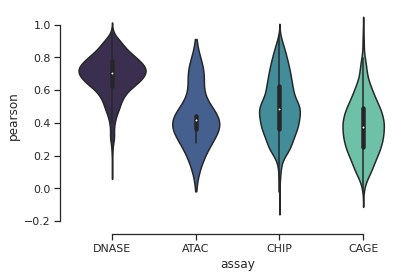

In [66]:
df

sns.set_theme(style="ticks", palette="pastel")

# Load the example tips dataset

# Draw a nested boxplot to show bills by day and time
sns.violinplot(x="assay", y="pearson",  palette="mako", linewidth=1.5,
            data=df)
sns.despine(offset=10, trim=True)

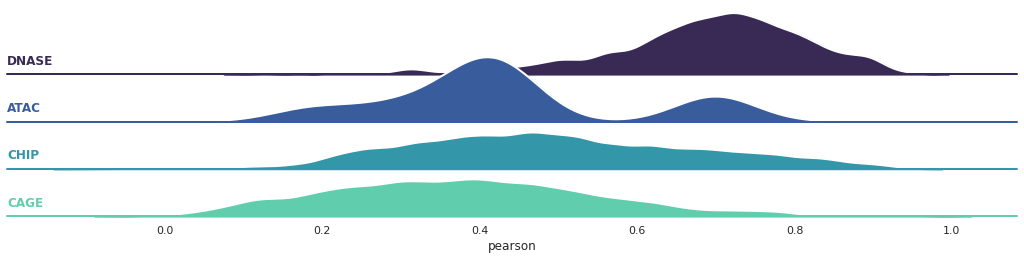

In [67]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize 
g = sns.FacetGrid(df, row="assay", hue="assay", aspect=15, height=1, palette="mako")

# Draw the densities in a few steps
g.map(sns.kdeplot, "pearson",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "pearson", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "pearson")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.3)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# OLD (do not delete) - prepare  dictionary intervals

## Check if the sequences are in order

In [ ]:
df = pd.read_csv(human_sequences, memory_map=True, header=None, index_col=False, delimiter="\t")
# keep only validation intervals 
validation_intervals= df[df[3]=="valid"]
#validation_intervals = validation_intervals.head()
# create list with interval
interval_list = list()
validation_intervals.apply(lambda row : interval_list.append(kipoiseq.Interval(row[0],row[1], row[2])), axis = 1)

In [ ]:
# Create dictionary for search (can be improved! quite slow)
human_validation_dict = {}
for interval in interval_list: 
    sequence = one_hot_encode(fasta_extractor.extract(interval))
    human_validation_dict[interval] = sequence

In [ ]:
# Step 1
import pickle

enformer_dict_file = os.path.join(outputdir,'00_enformer_dict_seqs.h5')
# Step 2
with open(enformer_dict_file, 'wb') as config_dictionary_file:
    pickle.dump(human_validation_dict, config_dictionary_file)
    
# -------- read -------
with open(enformer_dict_file, 'rb') as config_dictionary_file:
    config_dictionary = pickle.load(config_dictionary_file)

print(config_dictionary)

In [ ]:
outputdir

## Convert Human dataset into list 

In [ ]:
human_dataset_list = []
for i, batch in tqdm(enumerate(human_dataset)):
    human_dataset_list.append(batch)

file = os.path.join(outputdir,'human_dataset.h5')

# Step 2
with open(file, 'wb') as config_dictionary_file:
    pickle.dump(human_dataset_list, config_dictionary_file)